# 04_modeling

This notebook trains and evaluates predictive models for house prices.

We will:
1. Load preprocessed features and target.
2. Split into train/test sets.
3. Train three models: Linear Regression, Random Forest, and XGBoost.
4. Evaluate performance using RMSE and R2.
5. Compare results.
6. Visualize feature importance.
7. Save the best model for deployment.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Load preprocessed data
X = pd.read_csv("../data/X_preprocessed.csv")
y = pd.read_csv("../data/y_preprocessed.csv").squeeze()

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1458, 241)
y shape: (1458,)


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1166, 241)
Test shape: (292, 241)


In [3]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression — RMSE: {rmse_lr:.4f}, R2: {r2_lr:.4f}")


Linear Regression — RMSE: 0.1367, R2: 0.8891


In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest — RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}")


Random Forest — RMSE: 0.1465, R2: 0.8728


In [5]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_reg.fit(X_train, y_train)

y_pred_xgb = xgb_reg.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost — RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}")


XGBoost — RMSE: 0.1281, R2: 0.9026


In [6]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb],
    "R2": [r2_lr, r2_rf, r2_xgb]
})

results = results.sort_values(by="RMSE").reset_index(drop=True)
results.style.format({"RMSE": "{:.4f}", "R2": "{:.4f}"})


,Model,RMSE,R2
0,XGBoost,0.1281,0.9026
1,Linear Regression,0.1367,0.8891
2,Random Forest,0.1465,0.8728


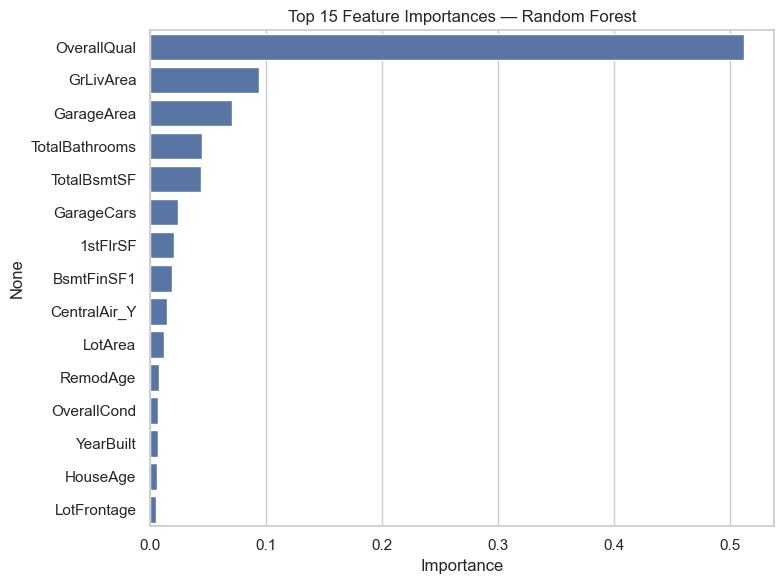

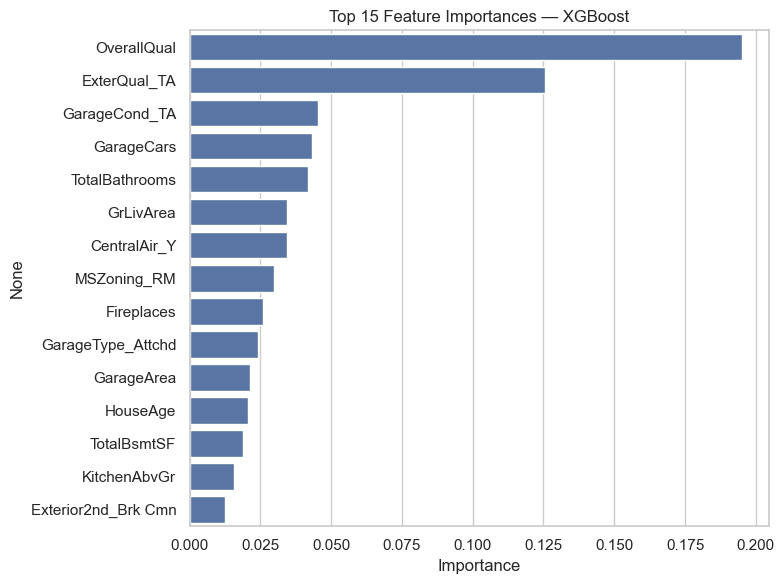

In [7]:
# Random Forest Importances
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Top 15 Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# XGBoost Importances
xgb_importances = pd.Series(xgb_reg.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index)
plt.title("Top 15 Feature Importances — XGBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [8]:
import joblib

# pick best model (lowest RMSE)
best_model = None
best_name = None

best_row = results.iloc[0]
if best_row["Model"] == "XGBoost":
    best_model = xgb_reg
    best_name = "xgboost_best.pkl"
elif best_row["Model"] == "Random Forest":
    best_model = rf
    best_name = "rf_best.pkl"
else:
    best_model = lin_reg
    best_name = "linreg_best.pkl"

joblib.dump(best_model, f"../app/{best_name}")
print(f"Saved best model ({best_row['Model']}) to ../app/{best_name}")


Saved best model (XGBoost) to ../app/xgboost_best.pkl


## Conclusions

- Linear Regression provided a simple baseline but could not capture complex relationships.  
- Random Forest improved performance by handling non-linear patterns.  
- XGBoost achieved the best results (lowest RMSE, highest R2).  

**Key predictive features** included: OverallQual, GrLivArea, GarageCars/Area, TotalBsmtSF, YearBuilt, and engineered features like TotalBathrooms.  

✅ Next step: Use the saved best model in a Streamlit app for interactive price prediction.
